In [0]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ROOT_FOLDER = "/content/drive/My Drive/Jorey"
#ROOT_FOLDER = "/content/drive/My Drive/TheOneAI/Jorey"

!ls "/content/drive/My Drive/Jorey"
#!ls "/content/drive/My Drive/TheOneAI/Jorey"

BDD_AI_with_FORME_TYPIQUE_complete.csv
final_data_frame.csv
final_data_frame.xlsx
final_file_03.csv
imagens6
Load_sheet.ipynb
models
new_images_04_11
original_final_file_csv.csv
pretrained_predict_collor.ipynb
pretrained_predict_collor.pth
pretrained_predict_type.ipynb
pretrained_predict_type.pth
similaraty_of_cosine.ipynb
train_original_images_folder_imagens_6.ipynb
train_overall_images.ipynb
vectorized_images.json


In [0]:
##########################
# SOME IMPORT STATEMENTS #
##########################
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

In [0]:
######################
# INSTALLING PYTORCH #
######################
import sys
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print('accelerator:', accelerator)
#print('python version:', sys.version)

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
#!pip3 install torch torchvision

from __future__ import print_function, division
import os
import json
import time

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from skimage import io, transform


print('installed torch version:', torch.__version__)

     |████████████████████████████████| 753.6MB 73.8MB/s 
installed torch version: 1.0.0


In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
from PIL import Image


def rgba_to_rgb(image, color=(255, 255, 255)):
    """Set all fully transparent pixels of an RGBA image to the specified color.
    This is a very simple solution that might leave over some ugly edges, due
    to semi-transparent areas. You should use alpha_composite_with color instead.

    Source: http://stackoverflow.com/a/9166671/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    x = np.array(image)
    r, g, b, a = np.rollaxis(x, axis=-1)
    r[a == 0] = color[0]
    g[a == 0] = color[1]
    b[a == 0] = color[2] 
    x = np.dstack([r, g, b])
    if isinstance(image, np.ndarray):
      return x
    elif isinstance(image, Image.Image):
      return Image.fromarray(x, 'RGB')
    else:
      print("ERROR: unknown image type:", type(image))
      return None


def arr_to_pil(arr):
  """
  Convert numpy array to PIL image with default mode (either B&W, or RGB, or RGBA)
  """
  return Image.fromarray(arr)


def pil_to_arr(pil):
  """
  Convert PIL image to numpy array
  """
  return np.array(pil)


def normalize(image, verbose=True):
  """
  Convert 4 channel images (RGBA) to 3 channels (RGB)
  Convert 0 channel images (B&W) to 3 channels (RGB)
  """
  # make sure we have a numpy array as image
  image = np.array(image)
  
  if len(image.shape) > 2 and image.shape[2] == 4:
    if verbose: print("converting RGBA to RGB image")
    image = rgba_to_rgb(image)

  elif len(image.shape) == 2:
    if verbose: print("converting black & white image to RGB image")
    image = arr_to_pil(image)
    image = image.convert('RGB')
    image = pil_to_arr(image)
  return image

     |████████████████████████████████| 5.7MB 3.3MB/s 
ERROR: scikit-image 0.14.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


original type: <class 'numpy.ndarray'>
original shape: (400, 300, 3)
original image


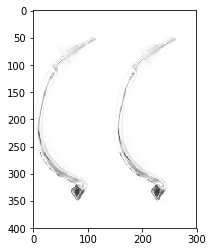

In [0]:
# Read in the image
# - #437 is RGBA
# - #438 is black and white :/
# - #439 is RGB

try:
  image = matplotlib.image.imread(ROOT_FOLDER + '/new_images_04_11/1014.jpg')
except ValueError:
  image = matplotlib.image.imread(ROOT_FOLDER + '/new_images_04_11/1014.png')

'''
.PNG - passed test @12:28 16/04/2019
32   76   272  297  336  386
488  491  492  528  564  589  592   835
836  865  866  881  882  892  2798

.PNG - failed test @12:28 16/04/2019
2809
|_ ok with .JPG
'''

#print(image)
print('original type:', type(image))
print('original shape:', np.array(image).shape)
print('original image')
plt.imshow(image)

new type: <class 'numpy.ndarray'>
new shape: (400, 300, 3)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
new image:


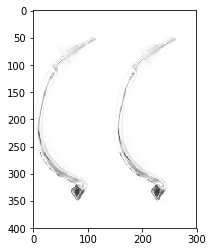

In [0]:
image = normalize(image)
print('new type:', type(image))
print('new shape:', np.array(image).shape)
print(image)
print('new image:')
plt.imshow(image)

In [0]:
data_frame = pd.read_csv(
    ROOT_FOLDER + "/final_data_frame.csv",
    delimiter = ',',
    #delimiter = ';',
    encoding='utf-8',
    #encoding='latin-1',
    error_bad_lines=False,
    usecols=["id","TYPE","Collor_Metal","TRANCHE_DAGE_SIMPLE","FORME_TYPIQUE_SIMPLE", "PORTEE", "image_name"]
)

data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3274 entries, 0 to 3273
Data columns (total 7 columns):
TYPE                    3274 non-null object
Collor_Metal            3274 non-null object
TRANCHE_DAGE_SIMPLE     3274 non-null object
FORME_TYPIQUE_SIMPLE    3274 non-null object
PORTEE                  3274 non-null object
id                      3274 non-null int64
image_name              3274 non-null object
dtypes: int64(1), object(6)
memory usage: 179.1+ KB


In [0]:
print("TYPES:")
data_frame['TYPE'].value_counts()


TYPES:


Boucles d'oreilles     1110
Bracelet                891
Bague                   878
Collier / Pendentif     395
Name: TYPE, dtype: int64

In [0]:
print("Collor_Metal")
data_frame['Collor_Metal'].value_counts()

Collor_Metal


Gris     1173
Jaune    1118
Rose      658
Autre     325
Name: Collor_Metal, dtype: int64

In [0]:

print("FORME_TYPIQUE_SIMPLE")
data_frame['FORME_TYPIQUE_SIMPLE'].value_counts()

FORME_TYPIQUE_SIMPLE


Autre                       608
Bracelet Chaîne             514
BO Pendant                  368
BO Puces                    352
Collier_Pendentif_chaine    305
Bague Motif sur jonc        283
Bracelet Jonc               247
Bague Bandeau               238
BO Motif                    208
Bague Solitaire             151
Name: FORME_TYPIQUE_SIMPLE, dtype: int64

In [0]:
print("TRANCHE_DAGE_SIMPLE")
data_frame['TRANCHE_DAGE_SIMPLE'].value_counts()

TRANCHE_DAGE_SIMPLE


Indifférent        1858
20 à 35             709
Moins de 20 ans     534
Plus de 35          173
Name: TRANCHE_DAGE_SIMPLE, dtype: int64

In [0]:

print("PORTEE")
data_frame['PORTEE'].value_counts()

PORTEE


Tous les jours    2878
Soir               211
Fiançailles        185
Name: PORTEE, dtype: int64

In [0]:
#####################################
# TRANSFORMING THE DATA INTO NUMERS #
#####################################

data_frame['TYPE']       = data_frame.TYPE.astype("category").cat.codes
data_frame['Collor_Metal']    = data_frame.Collor_Metal.astype("category").cat.codes
data_frame['FORME_TYPIQUE_SIMPLE']    = data_frame.FORME_TYPIQUE_SIMPLE.astype("category").cat.codes
data_frame['TRANCHE_DAGE_SIMPLE']    = data_frame.TRANCHE_DAGE_SIMPLE.astype("category").cat.codes
data_frame['PORTEE']    = data_frame.PORTEE.astype("category").cat.codes


data_frame.head()


,TYPE,Collor_Metal,TRANCHE_DAGE_SIMPLE,FORME_TYPIQUE_SIMPLE,PORTEE,id,image_name
0,0,1,0,0,0,1,1.jpg
1,0,2,0,0,0,2,2.jpg
2,0,2,0,0,0,3,3.jpg
3,0,2,0,0,0,4,4.jpg
4,0,0,1,0,2,5,5.jpg


In [0]:
print("TYPES:")
data_frame['TYPE'].value_counts()

TYPES:


1    1110
2     891
0     878
3     395
Name: TYPE, dtype: int64

In [0]:
print("Collor_Metal:")
data_frame['Collor_Metal'].value_counts()

Collor_Metal:


1    1173
2    1118
3     658
0     325
Name: Collor_Metal, dtype: int64

In [0]:
print("TRANCHE_DAGE_SIMPLE:")
data_frame['TRANCHE_DAGE_SIMPLE'].value_counts()

TRANCHE_DAGE_SIMPLE:


1    1858
0     709
2     534
3     173
Name: TRANCHE_DAGE_SIMPLE, dtype: int64

In [0]:
print("FORME_TYPIQUE_SIMPLE:")
data_frame['FORME_TYPIQUE_SIMPLE'].value_counts()

FORME_TYPIQUE_SIMPLE:


0    608
7    514
2    368
3    352
9    305
5    283
8    247
4    238
1    208
6    151
Name: FORME_TYPIQUE_SIMPLE, dtype: int64

In [0]:
print("PORTEE:")
data_frame['PORTEE'].value_counts()

PORTEE:


2    2878
1     211
0     185
Name: PORTEE, dtype: int64

In [0]:
print("TRANCHE_DAGE_SIMPLE")
data_frame['TRANCHE_DAGE_SIMPLE'].value_counts()

TRANCHE_DAGE_SIMPLE


1    1858
0     709
2     534
3     173
Name: TRANCHE_DAGE_SIMPLE, dtype: int64

In [0]:
data_frame[data_frame['id']==2037]

,TYPE,Collor_Metal,TRANCHE_DAGE_SIMPLE,FORME_TYPIQUE_SIMPLE,PORTEE,id,image_name
2016,2,1,1,7,2,2037,2037.jpg


In [0]:
#########################
# TODO: verify the mapping
#########################

idx_to_str_type = {
    0: 'bague',
    1: "boucle doreille",
    3: 'collier / pendentif',
    2: 'bracelet'
}


idx_to_str_collor_metal = {
    1: 'gris',
    2: 'jaune',
    3: 'rose',
    0: 'autre'
}





idx_to_str_TRANCHE_DAGE_SIMPLE = {
    1: 'Indifferent',
    2: 'moin_20_ans',
    3: 'plus_35',
    0: '20_35_ans'
}


idx_to_str_PORTEE = {
    2: 'Tous les jours',
    1: 'Soir',
    0: 'Fiançailles'
}


idx_to_str_FORME_TYPIQUE_SIMPLE = {
    1: 'BO Motif',
    2: 'BO Pendant',
    3: 'BO Puces',
    4: 'Bague Bandeau',
    5: 'Bague Motif sur jonc',
    6: 'Bague Solitaire',
    7: 'Bracelet Chaine',
    8: 'Bracelet Jonc',
    9: 'Collier_Pendentif_chaine',
    0: 'Autre'  
    
}

# ---------------------------------

str_to_idx_type = {
    'bague': 0,
    "boucle doreille": 1,
    'collier / pendentif': 3,
    'bracelet': 2
    
}

str_to_idx_collor_metal = {
    'gris': 1,
    'jaune': 2,
    'rose': 3,
    'autre': 0
}

str_to_idx_TRANCHE_DAGE_SIMPLE = {
    'Indifferent': 1,
    '20_30_ans': 0,
    'moin_20_ans': 2,
    'plus_35': 3
}

str_to_idx_PORTEE = {
    'Fiançailles': 0,
    'Soir': 1,
    'Tous les jours': 2
    
}


 

str_to_idx_FORME_TYPIQUE_SIMPLE = {
    'Bague Motif sur jonc': 5,
    'BO Pendant': 2,
    'Bague Solitaire': 6,
    'BO Puces': 3,
    'BO Motif': 1,
    'Collier_Pendentif_chaine': 9,
    'Bague Bandeau': 4,
    'Bracelet Chaîne': 7,
    'Bracelet Jonc': 8,
    'Autre':0
    
}


In [0]:
img_name = data_frame.iloc[line, -1]
img_name

'2057.jpg'

In [0]:
line = 2036

# TODO: make sure that the order of the dataframe is the same
#id	TYPE	Collor_Metal	TRANCHE_DAGE_SIMPLE	FORME_TYPIQUE_SIMPLE	PORTEE	image_name

img_name = data_frame.iloc[line, -1]
img_type = data_frame.iloc[line, 1]
img_metal_color = data_frame.iloc[line, 2]
TRANCHE_DAGE_SIMPLE = data_frame.iloc[line, 3]
FORME_TYPIQUE_SIMPLE = data_frame.iloc[line, 4]
PORTEE = data_frame.iloc[line, 5]


print('Image name: {}'.format(img_name))
print('Image type: {}'.format(img_type))

print('Image type: {}'.format(idx_to_str_type[img_type]))

print('Image metal_color: {}'.format(img_metal_color))


print('Image metal_color: {}'.format(idx_to_str_collor_metal[img_metal_color]))



#print('Image TRANCHE_DAGE_SIMPLE: {}'.format(TRANCHE_DAGE_SIMPLE))
#print('Image TRANCHE_DAGE_SIMPLE: {}'.format(idx_to_str_TRANCHE_DAGE_SIMPLE[TRANCHE_DAGE_SIMPLE]))

#print('Image PORTEE: {}'.format(PORTEE))
#print('Image PORTEE: {}'.format(idx_to_str_PORTEE[PORTEE]))

print('Image FORME_TYPIQUE_SIMPLE: {}'.format(FORME_TYPIQUE_SIMPLE))
print('Image FORME_TYPIQUE_SIMPLE: {}'.format(idx_to_str_FORME_TYPIQUE_SIMPLE[FORME_TYPIQUE_SIMPLE]))

Image name: 2057.jpg
Image type: 1
Image type: boucle doreille
Image metal_color: 2
Image metal_color: jaune
Image FORME_TYPIQUE_SIMPLE: 2
Image FORME_TYPIQUE_SIMPLE: BO Pendant


In [0]:
class JoreyDataSets(Dataset):

    def __init__(self, data_frame, root_dir, transform=None):
        """
        Args:
            data_frame (panda data frame)
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(
            self.root_dir,
            self.data_frame.iloc[idx, -1]  # make sure this is the image name
        )

        #image = io.imread(img_name)
        image = matplotlib.image.imread(img_name,0)
        #print(img_name)
        # make sure to get 3 channel images
        image = normalize(image, verbose=False)
        
        #labels = self.data_frame.iloc[idx, 0:5].values
        labels = self.data_frame.iloc[idx, 0:5].to_numpy()
        labels = labels.astype('float32')
        
        sample = {'image': image, 'labels': labels}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [0]:
data_frame.iloc[2, 0:5]

TYPE                    0
Collor_Metal            2
TRANCHE_DAGE_SIMPLE     0
FORME_TYPIQUE_SIMPLE    0
PORTEE                  0
Name: 2, dtype: object

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    This will also ignore the 4th channel in the 3rd dimention if there is one

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        # print(sample)
        image         = sample['image']
        labels        = sample['labels']
        #onehot_labels = sample['onehot_labels']
        
        # modifying the height & width
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w), mode='constant')

        return {
            'image': img,
            'labels': labels#,
            #'onehot_labels': onehot_labels
        }


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image         = sample['image']
        labels        = sample['labels']
        
        
        #onehot_labels = sample['onehot_labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        #print(torch.from_numpy(image).float())
        
        return {
            'image': torch.from_numpy(image).float(),
            'labels': labels#,
            #'onehot_labels': onehot_labels
        }

ORIGINAL picture #1938
image shape: (400, 300, 3)
string labels: TYPE =  boucle doreille & Collor Metal =  gris & TRANCHE_DAGE_SIMPLE =  20_35_ans & FORME_TYPIQUE_SIMPLE =  BO Pendant


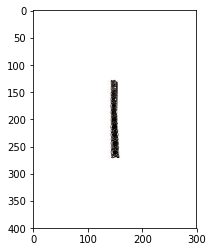

ORIGINAL picture #1096
image shape: (400, 300, 3)
string labels: TYPE =  bracelet & Collor Metal =  gris & TRANCHE_DAGE_SIMPLE =  Indifferent & FORME_TYPIQUE_SIMPLE =  BO Pendant


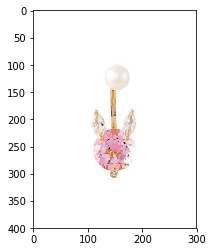

In [0]:
jorey_dataset = JoreyDataSets(
    data_frame = data_frame,
    root_dir = ROOT_FOLDER + '/new_images_04_11',
    transform=None  # ORIGINAL IMAGES
)

indices = list(range(len(jorey_dataset)))
random.shuffle(indices)

to_print = 2


for i in indices:
  if to_print == 0:
    break

  print("ORIGINAL picture #%d" % i)
  
  sample = jorey_dataset[i]
  #print(sample)
  print('image shape:', sample['image'].shape)
  #print('labels:', sample['labels'])
  
  print('string labels: TYPE = ',
        idx_to_str_type[int(sample['labels'][1])],
        '& Collor Metal = ',
        idx_to_str_collor_metal[int(sample['labels'][2])],
        '& TRANCHE_DAGE_SIMPLE = ',
        idx_to_str_TRANCHE_DAGE_SIMPLE[int(sample['labels'][3])],
        '& FORME_TYPIQUE_SIMPLE = ',
        idx_to_str_FORME_TYPIQUE_SIMPLE[int(sample['labels'][4])]
  )

 
  plt.figure()
  plt.imshow(sample['image'])
  plt.show()
  
  to_print -= 1


SCALED picture #1938
image shape: (256, 256, 3)
string labels: TYPE =  boucle doreille & Collor Metal =  gris & TRANCHE_DAGE_SIMPLE =  20_35_ans & FORME_TYPIQUE_SIMPLE =  BO Pendant


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


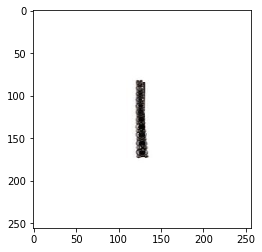

SCALED picture #1096
image shape: (256, 256, 3)
string labels: TYPE =  bracelet & Collor Metal =  gris & TRANCHE_DAGE_SIMPLE =  Indifferent & FORME_TYPIQUE_SIMPLE =  BO Pendant


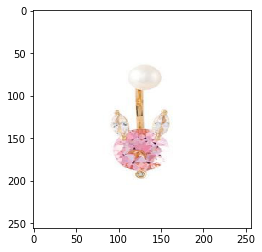

In [0]:
scale = Rescale((256, 256))
to_tensor = ToTensor()

to_print = 2

for i in indices:
  if to_print == 0:
    break

  print("SCALED picture #%d" % i)
  sample = jorey_dataset[i]
  sample = scale(sample)
  # save image to plot
  image_to_show = sample['image']
  # apply ToTensor() transformation
  #sample = to_tensor(sample)

  print('image shape:', sample['image'].shape)
  #print('labels:', sample['labels'])
  #print('onehot_labels:', sample['onehot_labels'])

  print('string labels: TYPE = ',
        idx_to_str_type[int(sample['labels'][1])],
        '& Collor Metal = ',
        idx_to_str_collor_metal[int(sample['labels'][2])],
        '& TRANCHE_DAGE_SIMPLE = ',
        idx_to_str_TRANCHE_DAGE_SIMPLE[int(sample['labels'][3])],
        '& FORME_TYPIQUE_SIMPLE = ',
        idx_to_str_FORME_TYPIQUE_SIMPLE[int(sample['labels'][4])]
  )

 
  plt.figure()
  plt.imshow(sample['image'])
  plt.show()
  
  to_print -= 1


In [0]:
#
# define utils functions to split data
#
def split_random(dataset, train_amount=0.8, valid_amount=0.1):
    """
    Split a given dataset into train, valid, test sets
    :param dataset: the data to split
    """
    data_size = len(dataset)
    data_indices = list(range(data_size))  # [0, 1, 2, ...., 2700]
    np.random.shuffle(data_indices)  # random permutation ~ [345, 738, 0, ..., 45]

    train_index_stop = int(data_size * train_amount)
    valid_index_stop = int(data_size * (train_amount + valid_amount))
    test_index_stop  = int(data_size * 1.0)

    train_indices = data_indices[0: train_index_stop]
    valid_indices = data_indices[train_index_stop: valid_index_stop]
    test_indices  = data_indices[valid_index_stop: ]

    train_data = torch.utils.data.Subset(dataset, train_indices)
    valid_data = torch.utils.data.Subset(dataset, valid_indices)
    test_data  = torch.utils.data.Subset(dataset, test_indices)
    
    return train_data, valid_data, test_data

    
def split_equal(dataset, category, train_amount=0.8, valid_amount=0.1):
    """
    Split a given dataset into train, valid, test sets
    :param dataset: the data to split
    :param category: a column from the original dataframe
    """
    # NEW WAY OF DOING IT : HAVE THE SAME NUMBER OF IMAGES FOR EVERY VALUE IN THE SPECIFIED CATEGORY
    train_indices = []
    valid_indices = []
    test_indices = []
    
    print("total data size:", len(dataset))
    
    print("number of training images should be around ",  int(len(dataset) * train_amount))
    print("number of validation images should be around ",  int(len(dataset) * valid_amount))
    print("number of test images should be around ",  int(len(dataset) * (1.0 - train_amount - valid_amount)))
    
    possible_values = dataset.data_frame[category].value_counts().count()
    print("number of possible values for category", category, "is", possible_values)
    
    #max_images_in_train = int( len(dataset) * train_amount )
    #max_images_in_valid = int( len(dataset) * valid_amount )
    #max_images_in_test =  int( len(dataset) * (1.0 - train_amount - valid_amount) )
    #print("max images in the train set:", max_images_in_train)
    #print("max images in the valid set:", max_images_in_valid)
    #print("max images in the testing set:", max_images_in_test)
    
    max_images_in_train_per_label = {}
    max_images_in_valid_per_label = {}
    max_images_in_test_per_label = {}
    for label in range(possible_values):
        max_images_in_train_per_label[label] = int(dataset.data_frame[category].value_counts()[label] * train_amount)
        max_images_in_valid_per_label[label] = int(dataset.data_frame[category].value_counts()[label] * valid_amount)
        max_images_in_test_per_label[label] = int(dataset.data_frame[category].value_counts()[label] * (1.0 - train_amount - valid_amount))
    
    print("max images for each category in the train set:", max_images_in_train_per_label)
    print("max images for each category in the valid set:", max_images_in_valid_per_label)
    print("max images for each category in the testing set:", max_images_in_test_per_label)
    
    #train_counter = {}  # map from label to number of images with that label ex: 'rose':12 , 'jaune':13 , etc...
    #valid_counter = {}  # map from label to number of images with that label
    #test_counter = {}  # map from label to number of images with that label
    # initialize the counter to 0 for every label
    #for label in range(possible_values):
    #    train_counter[label] = 0
    #    valid_counter[label] = 0
    #    test_counter[label] = 0
    #    # print(label)
    
    for idx, sample in enumerate(dataset):
        '''
        TYPE                
        Collor_Metal        
        TRANCHE_DAGE_SIMPLE 
        FORME_TYPIQUE_SIMPLE
        PORTEE              
        '''
        a_type, a_collor_metal, a_tranche_dage_simple, a_forme_typique_simple,  a_portee = sample['labels']
        
        # define the label to consider
        if category == 'TYPE':
          important_label = a_type
        elif category == 'Collor_Metal':
          important_label = a_collor_metal
        elif category == 'TRANCHE_DAGE_SIMPLE':
          important_label = a_tranche_dage_simple
        elif category == 'FORME_TYPIQUE_SIMPLE':
          important_label = a_forme_typique_simple
        elif category == 'PORTEE':
          important_label = a_portee
        else:
          print("ERROR: unknown category:", category)
          return None, None, None
        
        # if we are still missing images, then add this one to train set
        if max_images_in_train_per_label[important_label] > 0:
            train_indices.append(idx)
            max_images_in_train_per_label[important_label] -= 1
        elif max_images_in_valid_per_label[important_label] > 0:
            valid_indices.append(idx)
            max_images_in_valid_per_label[important_label] -= 1
        elif max_images_in_test_per_label[important_label] > 0:
            test_indices.append(idx)
            max_images_in_test_per_label[important_label] -= 1
        else:
            print("WARNING: we reached max capacity for label %s in train, valid, and test sets" % important_label)
            
        
    
    train_data = torch.utils.data.Subset(dataset, train_indices)
    valid_data = torch.utils.data.Subset(dataset, valid_indices)
    test_data  = torch.utils.data.Subset(dataset, test_indices)
    
    return train_data, valid_data, test_data

In [0]:
args = {
    'rescale': 256,
    'predictor': 'Collor_Metal'
}

use_gpu = torch.cuda.is_available()
if use_gpu:
  device_id = torch.cuda.current_device()
  print("device name:", torch.cuda.get_device_name(device_id))
else:
  print("on CPU :(")

transformed_dataset = JoreyDataSets(
    data_frame = data_frame,
    root_dir   = ROOT_FOLDER + '/new_images_04_11', 
    transform  = transforms.Compose(
        [Rescale((args['rescale'], args['rescale'])), ToTensor()]  # transforming the images into 256 x 256 squares and convert to tensor objects
    )
)

#train_data, valid_data, test_data = split_random(transformed_dataset)
train_data, valid_data, test_data = split_equal(transformed_dataset, args['predictor'])

print("train data:", len(train_data))
print("valid data:", len(valid_data))
print("test data:", len(test_data))

device name: Tesla T4
total data size: 3274
number of training images should be around  2619
number of validation images should be around  327
number of test images should be around  327
number of possible values for category Collor_Metal is 4
max images for each category in the train set: {0: 260, 1: 938, 2: 894, 3: 526}
max images for each category in the valid set: {0: 32, 1: 117, 2: 111, 3: 65}
max images for each category in the testing set: {0: 32, 1: 117, 2: 111, 3: 65}


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


train data: 2618
valid data: 325
test data: 325


In [0]:
args['batch_size'] = 32
args['n_workers']  = 4
args['max_epochs'] = 100

bs = args['batch_size']  # batch size is usually a power of 2, ex: 16, 32, 64, 128, 256, 512, 1024, 2048
n_workers = args['n_workers']
num_epochs = args['max_epochs']

'''
STEP 2: MAKING DATASET ITERABLE
This is very specific to pytorch.
'''
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=n_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=bs, shuffle=False, num_workers=n_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=n_workers)


In [0]:
import pprint
'''
Print statistics for training / validation / test set
Print the number of items for each category (TYPE, CollorMetal, etc...)
'''
# TODO:
# - pretty print the statistics (ex: json format or python pretty print) so that it is readable by us (not on one single line)
# - print the labels in their STRING format not their IDX by using the appropriate dictionary
for data_split, data in zip(('train', 'valid', 'test'), (train_data, valid_data, test_data)):

    statistics = {
        'TYPE': {},
        'Collor_Metal': {},
        'TRANCHE_DAGE_SIMPLE': {},
        'FORME_TYPIQUE_SIMPLE': {},
        'PORTEE': {}
    }
    for sample in data:
        a_type, a_collor_metal, a_tranche_dage_simple, a_forme_typique_simple , a_portee = sample['labels']
        
        # for Collor_Metal
        try:
          statistics['Collor_Metal'][idx_to_str_collor_metal[int(a_collor_metal)]] += 1
        except KeyError:
          statistics['Collor_Metal'][idx_to_str_collor_metal[int(a_collor_metal)]] = 1  
        # for TYPE
        try:
          statistics['TYPE'][idx_to_str_type[int(a_type)]] += 1
        except KeyError:
          statistics['TYPE'][idx_to_str_type[int(a_type)]] = 1
        # for TRANCHE_DAGE_SIMPLE
        try:
          statistics['TRANCHE_DAGE_SIMPLE'][idx_to_str_TRANCHE_DAGE_SIMPLE[int(a_tranche_dage_simple)]] += 1
        except KeyError:
          statistics['TRANCHE_DAGE_SIMPLE'][idx_to_str_TRANCHE_DAGE_SIMPLE[int(a_tranche_dage_simple)]] = 1
        # for FORME_TYPIQUE_SIMPLE
        try:
          statistics['FORME_TYPIQUE_SIMPLE'][idx_to_str_FORME_TYPIQUE_SIMPLE[int(a_forme_typique_simple)]] += 1
        except KeyError:
          statistics['FORME_TYPIQUE_SIMPLE'][idx_to_str_FORME_TYPIQUE_SIMPLE[int(a_forme_typique_simple)]] = 1
        # for PORTEE
        try:
          statistics['PORTEE'][idx_to_str_PORTEE[int(a_portee)]] += 1
        except KeyError:
          statistics['PORTEE'][idx_to_str_PORTEE[int(a_portee)]] = 1
    
    print(data_split, ':')
    
    for category, counts in statistics.items():
        print("\t", category)
        for value, count in counts.items():
          print("\t\t%s = %d / %d = %.4f" % (value, count, len(data), count/len(data)))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


train :
	 TYPE
		bague = 878 / 2618 = 0.3354
		boucle doreille = 1110 / 2618 = 0.4240
		bracelet = 630 / 2618 = 0.2406
	 Collor_Metal
		gris = 938 / 2618 = 0.3583
		jaune = 894 / 2618 = 0.3415
		autre = 260 / 2618 = 0.0993
		rose = 526 / 2618 = 0.2009
	 TRANCHE_DAGE_SIMPLE
		20_35_ans = 414 / 2618 = 0.1581
		Indifferent = 1709 / 2618 = 0.6528
		moin_20_ans = 366 / 2618 = 0.1398
		plus_35 = 129 / 2618 = 0.0493
	 FORME_TYPIQUE_SIMPLE
		Autre = 440 / 2618 = 0.1681
		Bague Bandeau = 238 / 2618 = 0.0909
		Bague Motif sur jonc = 283 / 2618 = 0.1081
		Bague Solitaire = 151 / 2618 = 0.0577
		BO Motif = 208 / 2618 = 0.0794
		BO Pendant = 368 / 2618 = 0.1406
		BO Puces = 352 / 2618 = 0.1345
		Bracelet Chaine = 505 / 2618 = 0.1929
		Bracelet Jonc = 73 / 2618 = 0.0279
	 PORTEE
		Fiançailles = 185 / 2618 = 0.0707
		Tous les jours = 2257 / 2618 = 0.8621
		Soir = 176 / 2618 = 0.0672
valid :
	 TYPE
		bracelet = 248 / 325 = 0.7631
		collier / pendentif = 77 / 325 = 0.2369
	 Collor_Metal
		rose = 65 / 3

In [0]:
import torch.nn as nn

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self, batch_size, n_class):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(batch_size * 64 * 64, n_class) 
    
    def forward(self, x):
        """
        This received a lot of images. And produce one vector for each image.
        :param x: is a batch of images. Tensor of shape ~~ (batch_size,  n_channels, height, width) ~~
        """
        #                     # ~(bs, 3, 256, 256)
        
        # Convolution 1
        h = self.cnn1(x)      # ~(bs, 16, 256, 256)
        h = self.relu1(h)
        
        # Max pool 1
        h = self.maxpool1(h)  # ~(bs, 16, 128, 128)
        
        # Convolution 2 
        h = self.cnn2(h)      # ~(bs, 32, 128, 128)
        h = self.relu2(h)
        
        # Max pool 2 
        h = self.maxpool2(h)  # ~(bs, 32, 64, 64)
        
        # Resize
        vec = h.view(h.size(0), -1)  # ~(bs, 32 * 64 * 64)

        # Linear function (readout)
        out = self.fc1(vec)          # ~(bs, n_class)
        
        return out, vec



In [0]:
def get_targets(dataframe, predictor):
    """
    Return the total number of possible values that can be found
    in column `predictor` from the dataframe
    AND
    return the column index of column `predictor`
    :param dataframe: dataframe object containing all data
    :param predictor: column id
    :return: the number of possible values for column `predictor`, and its column index
    """
    possible = dataframe[predictor].value_counts().count()
    idx = dataframe.columns.get_loc(predictor)
    return possible, idx

In [0]:
get_targets(data_frame, "PORTEE")

(3, 4)

In [0]:
def get_correct_dictionary(predictor):
  """
  return the mapping from IDX to STRING and the opposite mapping for the specified target (predictor)
  """
  if predictor == 'TYPE':
    return idx_to_str_type, str_to_idx_type
  elif predictor == 'Collor_Metal':
    return idx_to_str_collor_metal, str_to_idx_collor_metal
  elif predictor == 'TRANCHE_DAGE_SIMPLE':
    return idx_to_str_TRANCHE_DAGE_SIMPLE, str_to_idx_TRANCHE_DAGE_SIMPLE 
  elif predictor == 'FORME_TYPIQUE_SIMPLE':
    return idx_to_str_FORME_TYPIQUE_SIMPLE, str_to_idx_FORME_TYPIQUE_SIMPLE
  elif predictor == 'PORTEE':
    return idx_to_str_PORTEE, str_to_idx_PORTEE
  else:
    print("ERROR: unknown predictor : ", predictor)
    return None, None
  
 

In [0]:
get_correct_dictionary(args['predictor'])

({0: 'autre', 1: 'gris', 2: 'jaune', 3: 'rose'},
 {'autre': 0, 'gris': 1, 'jaune': 2, 'rose': 3})

In [0]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
num_targets, column_id = get_targets(data_frame, args['predictor'])

idx_to_str, str_to_idx = get_correct_dictionary(args['predictor'])


model = CNNModel(bs, num_targets)  # number of types = 4

model_id = 'classifier_' + args['predictor'] + '_' + str(time.time())

args['model_id'] = model_id

#######################
#  USE GPU FOR MODEL  #
#######################

if use_gpu:
    print("moving model to GPU...")
    model.cuda()
print("done.")

moving model to GPU...
done.


In [0]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()  # popular loss used in classification tasks


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

In [0]:
'''
STEP 7: TRAIN THE MODEL
'''

args['patience'] = 5

##################
# SAVE ARGUMENTS #
##################
with open(ROOT_FOLDER + '/models/' + model_id + '_args.json', 'w') as f:
  json.dump(args, f)
print('saved args.')

saved args.


In [0]:
def check_detailed_accuracy(data_loader):
    class_correct = list(0. for i in range(num_targets))
    class_total = list(0. for i in range(num_targets))
    with torch.no_grad():
        for i, sampled_batch in enumerate(data_loader):
              images = sampled_batch['image']
              labels = sampled_batch['labels']
              target = labels[:, column_id].long()  # TODO: check column_id is the correct variable

              #  USE GPU FOR MODEL  #
              if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

              outputs, _ = model(images)
              _, predicted = torch.max(outputs.data, 1)

              correct = (predicted == target)

              if correct.shape[0] > 1:
                  for i in range(len(correct)):
                      class_correct[target[i].item()] += correct[i].item()
                      class_total[target[i].item()] += 1

    for i in range(num_targets):
        if class_total[i] == 0:
            print("No datapoints for this category:", idx_to_str[i])
        else:
            print('Accuracy of %s : %.2d / %.2d = %.6f' % (idx_to_str[i], class_correct[i], class_total[i], class_correct[i]/class_total[i]))

In [0]:
timings = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': [],
    'patiences': [args['patience']]
}

patience = args['patience']

best_valid_loss = 2000.0  # keep track of the lowest validation error

for epoch in range(num_epochs):
  
    ########################
    # TRAINING STEPS BEGIN #
    ########################
    training_loss = 0.0
    training_step = 0.0
    
    correct = 0.0
    total = 0.0
    
    for i, sampled_batch in enumerate(train_loader):
      
        images = sampled_batch['image']
        labels = sampled_batch['labels']
        
        target = labels[:, column_id].long()
        #print(target)
        
        
        #  USE GPU FOR MODEL  #
        if torch.cuda.is_available():
            images = images.cuda()
            target = target.cuda()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs, _ = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, target)
        training_loss += loss.item()
        training_step += 1
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of targets
        this_batch_size = target.size(0)
        total += this_batch_size
        
        #  USE GPU FOR MODEL  #
        # Total correct predictions
        if torch.cuda.is_available():
            this_batch_correct = (predicted.cpu() == target.cpu()).sum()
        else:
            this_batch_correct = (predicted == target).sum()
        correct += this_batch_correct
        
        # print stats every 10 batch
        if i % 10 == 0:
          this_batch_acc = float(this_batch_correct) / float(this_batch_size)
          print("| epoch %.2d | batch %.3d | loss %.6f | acc %.2d/%.2d=%.6f |" % (
              epoch+1, i+1, loss.item(), this_batch_correct, this_batch_size, this_batch_acc
          ))
        
    training_loss = (training_loss / training_step)
    training_accuracy = float(correct) / float(total)
    # print('|-------------------------------------------------------------|')
    print('| epoch %.2d | train loss %.6f | train accuracy %.4d/%.4d=%.6f |' % (
        epoch+1, training_loss, correct, total, training_accuracy
    ))
    # print detailed accuracy for each category in the TRAINING set
    print("DETAILED ACCURACY ON THE TRAINING SET:")
    check_detailed_accuracy(train_loader)
    
    # save timings
    timings['train_loss'].append(training_loss)
    timings['train_acc'].append(training_accuracy)
    ######################
    # TRAINING STEPS END #
    ######################
    
    ##########################
    # VALIDATION STEPS BEGIN #
    ##########################

    # Calculate Accuracy         
    correct = 0
    total = 0
    valid_loss = 0.0
    valid_steps = 0.0
    # Iterate through validation dataset
    for sampled_batch in valid_loader:  # NOW WE USE VALIDATION DATA !
        images = sampled_batch['image']
        labels = sampled_batch['labels']
        
        target = labels[:, column_id].long()
        
        #  USE GPU FOR MODEL  #
        if torch.cuda.is_available():
            images = images.cuda()
            target = target.cuda()

        # Forward pass only to get logits/output
        outputs, _ = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, target)
        valid_loss += loss.item()
        valid_steps += 1

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of targets
        total += target.size(0)

        #  USE GPU FOR MODEL  #
        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == target.cpu()).sum()
        else:
            correct += (predicted == target).sum()

    valid_loss = (valid_loss / valid_steps)
    valid_accuracy = float(correct) / float(total)
    print('| epoch %.2d | valid loss %.6f | valid accuracy %.4d/%.4d=%.6f |' % (
        epoch+1, valid_loss, correct, total, valid_accuracy
    ))
    # print detailed accuracy for each category in the VALIDATION set
    print("DETAILED ACCURACY ON THE VALIDATION SET:")
    check_detailed_accuracy(valid_loader)
    
    # save timings
    timings['valid_loss'].append(valid_loss)
    timings['train_acc'].append(valid_accuracy)
    
    ##########################
    # VALIDATION STEPS END #
    ##########################
    
    ##########################
    # EARLY STOPPING BEGIN #
    ##########################

    # if valid_accuracy > max_valid_accuracy :
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience = args['patience']  # RESET patience to initial value
        # SAVE MODEL PARAMETERS
        torch.save(model.state_dict(), ROOT_FOLDER + '/models/' + model_id + '_best.pt')
        
        print("Model improved!\nSaved new model parameters!")
    else:
        patience -= 1  # REDUCE patience
        print("Model got worst :(\npatience: %d" % patience)
    
    timings['patiences'].append(patience)
    
    if patience <= 0:
      break  # STOP TRAINING LOOP
 
    
    ##########################
    # EARLY STOPPING STOP #
    ##########################

################
# SAVE TIMINGS #
################
with open(ROOT_FOLDER + '/models/' + model_id + '_timings.json', 'w') as f:
  json.dump(timings, f)
print('timings saved.')


# print detailed accuracy for each category in the TEST set
print("DETAILED ACCURACY ON THE TEST SET:")
check_detailed_accuracy(test_loader)

########################
# PLOT LEARNING CURVES #
########################

# TODO: plot training and validation losses
# TODO: plot training and validation accuracies

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 01 | batch 001 | loss 1.373388 | acc 06/32=0.187500 |
| epoch 01 | batch 011 | loss 1.374636 | acc 09/32=0.281250 |
| epoch 01 | batch 021 | loss 1.257887 | acc 13/32=0.406250 |
| epoch 01 | batch 031 | loss 1.413575 | acc 10/32=0.312500 |
| epoch 01 | batch 041 | loss 1.337588 | acc 15/32=0.468750 |
| epoch 01 | batch 051 | loss 1.162606 | acc 15/32=0.468750 |
| epoch 01 | batch 061 | loss 1.387271 | acc 09/32=0.281250 |
| epoch 01 | batch 071 | loss 1.279822 | acc 12/32=0.375000 |
| epoch 01 | batch 081 | loss 1.353821 | acc 09/32=0.281250 |
| epoch 01 | train loss 1.699267 | train accuracy 0976/2618=0.372804 |
DETAILED ACCURACY ON THE TRAINING SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 31 / 260 = 0.119231
Accuracy of gris : 429 / 938 = 0.457356
Accuracy of jaune : 754 / 894 = 0.843400
Accuracy of rose : 46 / 526 = 0.087452


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 01 | valid loss 1.313882 | valid accuracy 0128/0325=0.393846 |
DETAILED ACCURACY ON THE VALIDATION SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 00 / 32 = 0.000000
Accuracy of gris : 51 / 117 = 0.435897
Accuracy of jaune : 76 / 111 = 0.684685
Accuracy of rose : 01 / 65 = 0.015385
Model improved!
Saved new model parameters!


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 02 | batch 001 | loss 1.267957 | acc 15/32=0.468750 |
| epoch 02 | batch 011 | loss 1.159604 | acc 15/32=0.468750 |
| epoch 02 | batch 021 | loss 1.357035 | acc 12/32=0.375000 |
| epoch 02 | batch 031 | loss 1.138115 | acc 15/32=0.468750 |
| epoch 02 | batch 041 | loss 1.278478 | acc 15/32=0.468750 |
| epoch 02 | batch 051 | loss 1.029393 | acc 17/32=0.531250 |
| epoch 02 | batch 061 | loss 1.252159 | acc 12/32=0.375000 |
| epoch 02 | batch 071 | loss 1.201819 | acc 16/32=0.500000 |
| epoch 02 | batch 081 | loss 1.221497 | acc 14/32=0.437500 |
| epoch 02 | train loss 1.226518 | train accuracy 1179/2618=0.450344 |
DETAILED ACCURACY ON THE TRAINING SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 42 / 260 = 0.161538
Accuracy of gris : 393 / 938 = 0.418977
Accuracy of jaune : 791 / 894 = 0.884787
Accuracy of rose : 68 / 526 = 0.129278


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 02 | valid loss 1.400628 | valid accuracy 0105/0325=0.323077 |
DETAILED ACCURACY ON THE VALIDATION SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 00 / 32 = 0.000000
Accuracy of gris : 33 / 117 = 0.282051
Accuracy of jaune : 72 / 111 = 0.648649
Accuracy of rose : 00 / 65 = 0.000000
Model got worst :(
patience: 4


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 03 | batch 001 | loss 1.180505 | acc 13/32=0.406250 |
| epoch 03 | batch 011 | loss 1.094198 | acc 12/32=0.375000 |
| epoch 03 | batch 021 | loss 1.072116 | acc 15/32=0.468750 |
| epoch 03 | batch 031 | loss 1.277230 | acc 14/32=0.437500 |
| epoch 03 | batch 041 | loss 1.084616 | acc 15/32=0.468750 |
| epoch 03 | batch 051 | loss 1.152564 | acc 15/32=0.468750 |
| epoch 03 | batch 061 | loss 1.187614 | acc 17/32=0.531250 |
| epoch 03 | batch 071 | loss 0.974184 | acc 20/32=0.625000 |
| epoch 03 | batch 081 | loss 1.095919 | acc 17/32=0.531250 |
| epoch 03 | train loss 1.095677 | train accuracy 1345/2618=0.513751 |
DETAILED ACCURACY ON THE TRAINING SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 79 / 260 = 0.303846
Accuracy of gris : 662 / 938 = 0.705757
Accuracy of jaune : 826 / 894 = 0.923937
Accuracy of rose : 100 / 526 = 0.190114


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 03 | valid loss 1.643820 | valid accuracy 0142/0325=0.436923 |
DETAILED ACCURACY ON THE VALIDATION SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 00 / 32 = 0.000000
Accuracy of gris : 58 / 117 = 0.495726
Accuracy of jaune : 84 / 111 = 0.756757
Accuracy of rose : 00 / 65 = 0.000000
Model got worst :(
patience: 3


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 04 | batch 001 | loss 0.869981 | acc 21/32=0.656250 |
| epoch 04 | batch 011 | loss 0.977360 | acc 21/32=0.656250 |
| epoch 04 | batch 021 | loss 0.661652 | acc 22/32=0.687500 |
| epoch 04 | batch 031 | loss 0.709007 | acc 24/32=0.750000 |
| epoch 04 | batch 041 | loss 0.867549 | acc 22/32=0.687500 |
| epoch 04 | batch 051 | loss 0.657648 | acc 23/32=0.718750 |
| epoch 04 | batch 061 | loss 0.783975 | acc 23/32=0.718750 |
| epoch 04 | batch 071 | loss 0.956795 | acc 19/32=0.593750 |
| epoch 04 | batch 081 | loss 1.335667 | acc 22/32=0.687500 |
| epoch 04 | train loss 0.883750 | train accuracy 1741/2618=0.665011 |
DETAILED ACCURACY ON THE TRAINING SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 108 / 260 = 0.415385
Accuracy of gris : 887 / 938 = 0.945629
Accuracy of jaune : 587 / 894 = 0.656600
Accuracy of rose : 318 / 526 = 0.604563


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 04 | valid loss 1.694638 | valid accuracy 0165/0325=0.507692 |
DETAILED ACCURACY ON THE VALIDATION SET:


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Accuracy of autre : 00 / 32 = 0.000000
Accuracy of gris : 106 / 117 = 0.905983
Accuracy of jaune : 45 / 111 = 0.405405
Accuracy of rose : 14 / 65 = 0.215385
Model got worst :(
patience: 2


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

| epoch 05 | batch 001 | loss 0.742720 | acc 22/32=0.687500 |
| epoch 05 | batch 011 | loss 0.821561 | acc 21/32=0.656250 |
| epoch 05 | batch 021 | loss 0.884011 | acc 26/32=0.812500 |
| epoch 05 | batch 031 | loss 0.661416 | acc 25/32=0.781250 |


In [0]:

###############################
# OLD VERSION OF CHECK_DETAILED_ACCURACY
###############################

def check_detailed_accuracy(data_loader):
    class_correct = list(0. for i in range(num_targets))
    class_total = list(0. for i in range(num_targets))
    with torch.no_grad():
        for i, sampled_batch in enumerate(data_loader):
              images = sampled_batch['image']
              labels = sampled_batch['labels']
              target = labels[:, column_id].long()

              #  USE GPU FOR MODEL  #
              if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

              outputs, _ = model(images)
              _, predicted = torch.max(outputs.data, 1)

              correct = (predicted == target).squeeze()  # TODO: check if we need that?

              # if correct.shape[0] > 1:
              for i in range(len(correct)):
                  class_correct[target[i].item()] += correct[i].item()
                  class_total[target[i].item()] += 1

    for i in range(num_targets):
        if class_total[i] == 0:
            print("No datapoints for this category:", idx_to_str[i])
        else:
            print('Accuracy of %s : %.2d / %.2d = %.6f' % (idx_to_str[i], class_correct[i], class_total[i], class_correct[i]/class_total[i]))


No datapoints for this category: autre
No datapoints for this category: gris
Accuracy of jaune : 30 %
No datapoints for this category: rose
